In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from scipy.interpolate import griddata

plt.rcParams.update({'font.size': 14})

random.seed(1)

In [2]:
# import internal files
import emulator
import kernels
import data
import historymatch
import plot

In [3]:
def model_eqn_1(x, y):
    return np.cos(np.sqrt(x**2 + 2*y**2))      # banana
    #return np.cos(x)*np.sqrt(x**2 + 2*y**2)     # multiple regions
    
model1 = np.vectorize(model_eqn_1)

In [4]:
def model_eqn_2(x, y):
    #return np.sin(np.sqrt(x**2 + 4*y**2 + 2*a**2))
    return y**2 + x


model2 = np.vectorize(model_eqn_2)

In [5]:
# define parameter space
x_bound = np.array([-2, 2]).reshape(1,-1)
y_bound = np.array([-2, 2]).reshape(1,-1)
input_bounds = np.concatenate((x_bound, y_bound), axis=0)

xvals = np.linspace(input_bounds[0,0], input_bounds[0,1], 1000)
yvals = np.linspace(input_bounds[1,0], input_bounds[1,1], 1000)

In [6]:
# for testing: true datapoints

true_parameters_m1 = [-0.1, 0.3]
true_parameters_m2 = [-0.1, 0.2]

var_exp = 0.001        # observational uncertainty variance
z_1 = model_eqn_1(*true_parameters_m1) + np.random.normal(0, var_exp) # observed datapoint
z_2 = model_eqn_2(*true_parameters_m2) + np.random.normal(0, var_exp) # observed datapoint

var_method = 0.001

var_tot = var_exp + var_method

In [7]:
# simulation parameters
Ntraining = 50          # number of training points
ndim = 3        # model dimensions
Nsamples = 10000    # number of test points

In [8]:
def plot_1D(variable, model, true_parameters, z, var_tot, ax):
    if variable == 'x':
        true = true_parameters[0]
        true_other = true_parameters[1]
        vals = xvals
        model_args = [vals, true_other]
    elif variable == 'y':
        true = true_parameters[1]
        true_other = true_parameters[0]
        vals = yvals
        model_args = [true_other, vals]
    
    
    func = model(*model_args)
    ax.plot(vals, func)

    ax.axhline(z, color='black', linewidth=1, label='Obs Data')
    ax.axvline(true, color='red', linewidth=1, label='True Param')

    ax.axhline(z+3*np.sqrt(var_exp), color='black', linewidth=1, linestyle='--')
    ax.axhline(z-3*np.sqrt(var_exp), color='black', linewidth=1, linestyle='--', label = r'$\pm 3\sigma_{exp}$')

    idx1 = np.argwhere(np.diff(np.sign( func - z+3*np.sqrt(var_tot)))).flatten()  # upper
    idx2 = np.argwhere(np.diff(np.sign( func - z-3*np.sqrt(var_tot)))).flatten()  # lower
    
    idx = np.sort(np.concatenate((idx1, idx2), axis=None))
    
    if len(idx2) == 0:
        ax.axvspan(vals[idx1][0], vals[idx1][1], color='green', alpha=0.2, label='Nonimp region')
    elif len(idx1) == 0:
        ax.axvspan(vals[idx2][0], vals[idx2][1], color='green', alpha=0.2, label='Nonimp region')
    else:
        for i in np.arange(0, len(idx), 2):
            ax.axvspan(vals[idx][i], vals[idx][i+1], color='green', alpha=0.2, label='Nonimp region')
    ax.legend(loc='best')
    ax.set_ylabel(r'$f_1(x, y={})$'.format(true_other))
    ax.set_xlabel('x')

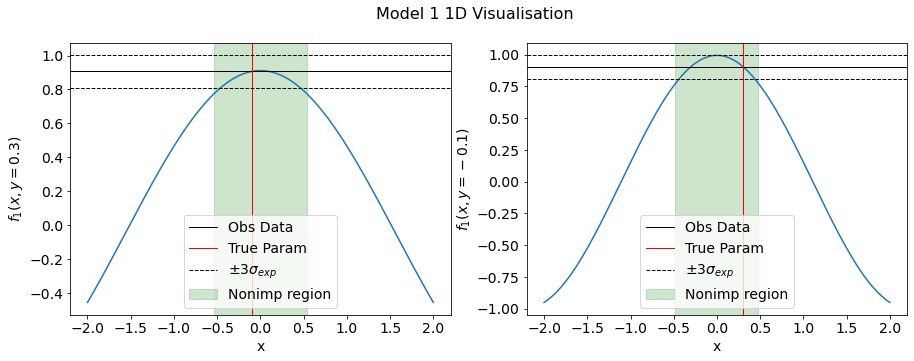

In [9]:
# visualise model 1
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Model 1 1D Visualisation', fontsize=16)

plot_1D('x', model1, true_parameters_m1, z_1, var_tot, ax1)
plot_1D('y', model1, true_parameters_m1, z_1, var_tot, ax2)


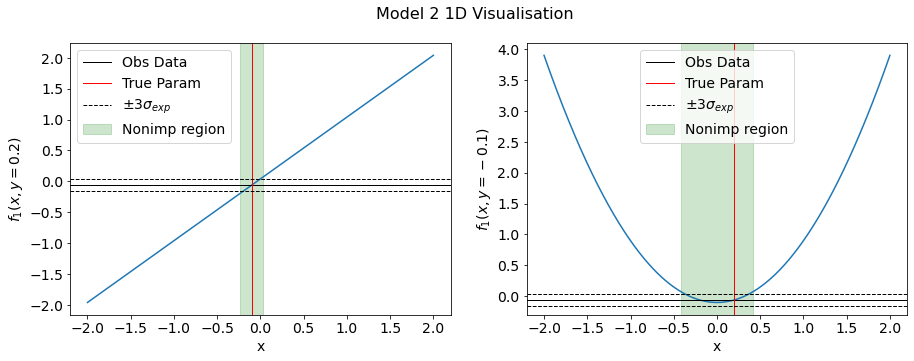

In [10]:
# visualise model 1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Model 2 1D Visualisation', fontsize=16)

plot_1D('x', model2, true_parameters_m2, z_2, var_tot, ax1)
plot_1D('y', model2, true_parameters_m2, z_2, var_tot, ax2)

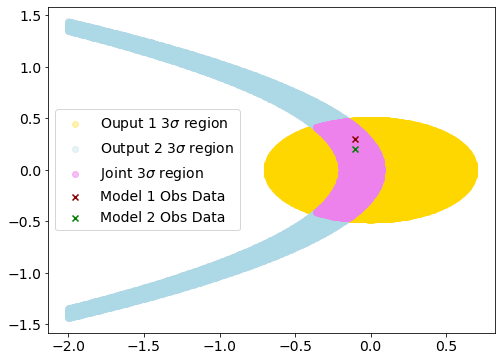

In [11]:
fig, ax1 = plt.subplots(1, figsize=(8,6))

X, Y = np.meshgrid(xvals, yvals)
func_1 = model1(X, Y)
func_2 = model2(X, Y)
xy_grid = np.zeros((len(xvals), len(yvals)))

# plot all parameter values
#ax1.scatter(X,Y, s=5, alpha=0.2)

# find outputs which are within 3sigma of the observed datapoint
idx_1 = np.argwhere(np.logical_and(func_1 > z_1-3*np.sqrt(var_tot), func_1 < z_1+3*np.sqrt(var_tot)))
idx_2 = np.argwhere(np.logical_and(func_2 > z_2-3*np.sqrt(var_tot), func_2 < z_2+3*np.sqrt(var_tot)))

# find joint 3sigma region
idx_joint = np.array([x for x in set(tuple(x) for x in idx_1) & set(tuple(x) for x in idx_2)])

# plot 3sigma range
ax1.scatter(xvals[idx_1[:,1]], yvals[idx_1[:,0]], color='gold', alpha=0.3, label=r'Ouput 1 $3\sigma$ region')
ax1.scatter(xvals[idx_2[:,1]], yvals[idx_2[:,0]], color='lightblue', alpha=0.3, label=r'Output 2 $3\sigma$ region')
ax1.scatter(xvals[idx_joint[:,1]], yvals[idx_joint[:,0]], color='violet', alpha=0.5, label=r'Joint $3\sigma$ region')

    
ax1.scatter(true_parameters_m1[0], true_parameters_m1[1], marker='x', color='darkred', label='Model 1 Obs Data')
ax1.scatter(true_parameters_m2[0], true_parameters_m2[1], marker='x', color='green', label='Model 2 Obs Data')

ax1.legend(loc='best')

In [12]:
# create squared-exponential kernel
sigma_cov = 0.25        # sqrt variance of covariance function
beta = 0         # prior expectation
theta = 1


kern = kernels.SE()

Current wave: 1


UnboundLocalError: local variable 'fig1' referenced before assignment

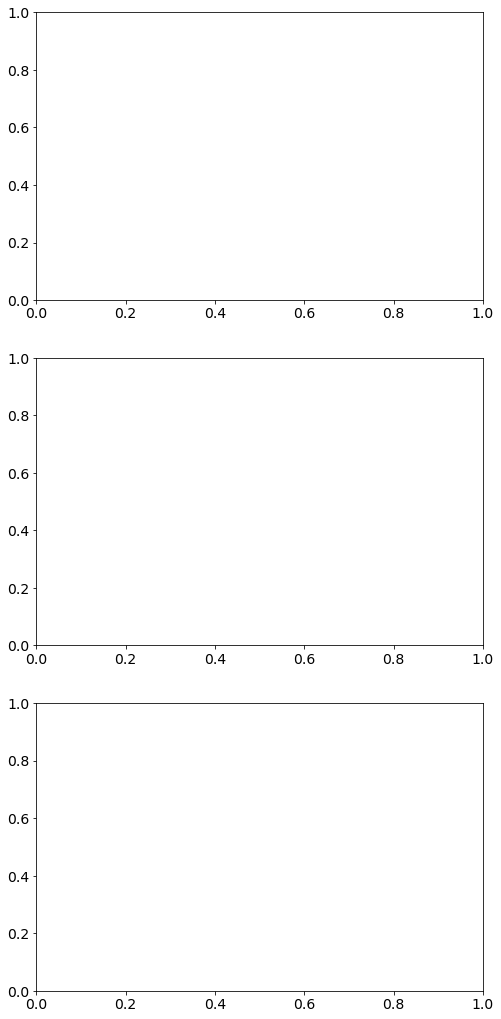

In [17]:
n_waves = 3

output1_mu, output1_sd, samples, wave_implaus = historymatch.history_match(kern, [model_eqn_1, model_eqn_2], input_bounds, sigma_cov, var_exp, var_method, beta, theta, 
              Ntraining, Nsamples, zlist=[z_1, z_2], ndim=2, n_outputs=2, waves=n_waves, xvals=xvals, yvals=yvals, idx_joint=idx_joint,
                             noise=True, sigma_n=0.02, plotOD=True)

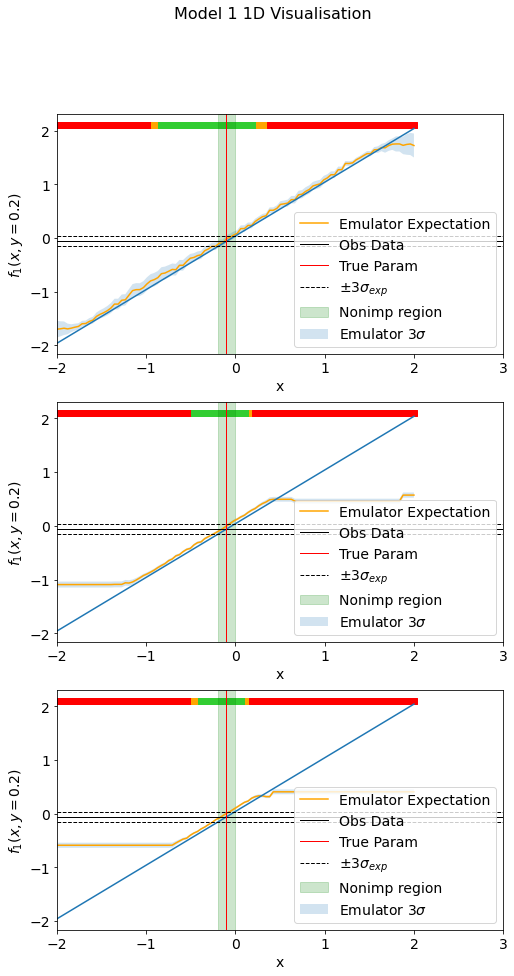

In [16]:
# visualise model in 1D

fig, axes = plt.subplots(n_waves, 1, figsize=(8,5*n_waves))
fig.suptitle('Model 1 1D Visualisation', fontsize=16)


for i in range(n_waves):
    
    ax1 = fig.axes[i]
    
    grid_x, grid_y = np.mgrid[input_bounds[0,0]:input_bounds[0,1]:100j, input_bounds[1,0]:input_bounds[1,1]:200j]

    
    grid_mean = griddata(samples[i], output1_mu[i], (grid_x, grid_y), method='nearest')
    grid_sd = griddata(samples[i], output1_sd[i], (grid_x, grid_y), method='nearest')
    grid_imp = griddata(samples[i], wave_implaus[i], (grid_x, grid_y), method='nearest')

    
    xrange = np.linspace(input_bounds[0,0],input_bounds[0,1],100)
    ax1.set_xlim([-2,3])
    
    ax1.plot(xrange, grid_mean[:,115], color='orange', label='Emulator Expectation')
    ax1.fill_between(xrange, grid_mean[:,115] + 3*grid_sd[:,115], grid_mean[:,115] - 3*grid_sd[:,115], alpha=0.2, label=r'Emulator $3\sigma$')

    for i in range(len(grid_mean[:,115])):
            if grid_imp[:,115][i] > 3.5:
                ax1.scatter(xrange[i], 2.1, color='red', marker='s')
            elif grid_imp[:,115][i] < 3:
                ax1.scatter(xrange[i], 2.1, color='limegreen', marker='s')
            else:
                ax1.scatter(xrange[i], 2.1, color='orange', marker='s')
                
    plot_1D('x', model2, true_parameters_m2, z_2, var_exp, ax1)